<a href="https://colab.research.google.com/github/lgvaz/projects/blob/master/vision/style/coco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch torchvision feather-format kornia pyarrow Pillow wandb nbdev --upgrade 
!pip install nbdev
!pip install git+https://github.com/fastai/fastcore
!pip install git+https://github.com/fastai/fastprogress  --upgrade
!pip install git+https://github.com/fastai/fastai2

In [0]:
# If you want to use all coco dataset
# !mkdir data
# !wget http://images.cocodataset.org/zips/unlabeled2017.zip -P data
# !cd data && unzip -q unlabeled2017.zip > null

In [0]:
import fastai2
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

In [2]:
# If in colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path("/content/gdrive/My Drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
path = untar_data(URLs.COCO_SAMPLE)/'train_sample'; path.ls()
# path = Path('data/unlabeled2017'); path.ls()

(#21837) [/root/.fastai/data/coco_sample/train_sample/000000530284.jpg,/root/.fastai/data/coco_sample/train_sample/000000288236.jpg,/root/.fastai/data/coco_sample/train_sample/000000353237.jpg,/root/.fastai/data/coco_sample/train_sample/000000570822.jpg,/root/.fastai/data/coco_sample/train_sample/000000497365.jpg,/root/.fastai/data/coco_sample/train_sample/000000165868.jpg,/root/.fastai/data/coco_sample/train_sample/000000477064.jpg,/root/.fastai/data/coco_sample/train_sample/000000301014.jpg,/root/.fastai/data/coco_sample/train_sample/000000047746.jpg,/root/.fastai/data/coco_sample/train_sample/000000129566.jpg...]

In [0]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=lambda *a, **kw: get_image_files(*a, **kw),
                   splitter=RandomSplitter(0.1, seed=42),
                   get_y=lambda x: x,
                 )

In [0]:
# Tuned for p100
# bs, sz = 8, 512
bs,sz = 22,256
dbch = dblock.databunch(path, bs=bs, item_tfms=[Resize(sz)], batch_tfms=[Normalize.from_stats(*imagenet_stats)])
dbch.c = 3

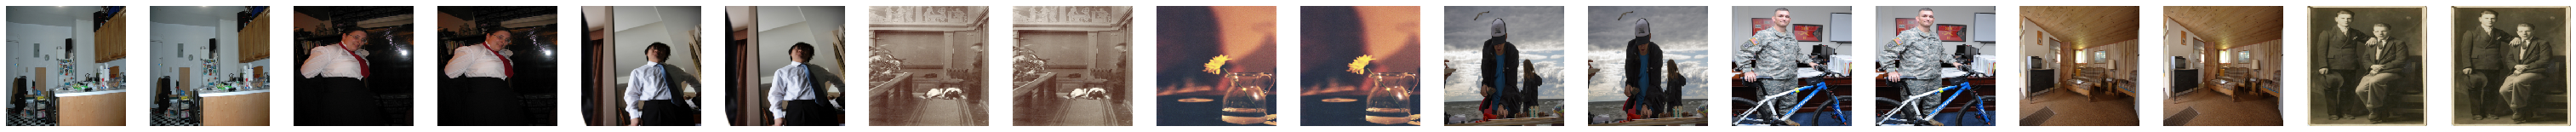

In [6]:
xb, yb = dbch.one_batch()
dbch.show_batch(rows=1)

--2019-12-16 02:47:18--  https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg
Resolving static.greatbigcanvas.com (static.greatbigcanvas.com)... 23.21.117.127
Connecting to static.greatbigcanvas.com (static.greatbigcanvas.com)|23.21.117.127|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445921 (435K) [image/jpeg]
Saving to: ‘style.jpg’

style.jpg           100%[===================>] 435.47K   779KB/s    in 0.6s    

2019-12-16 02:47:19 (779 KB/s) - ‘style.jpg’ saved [445921/445921]



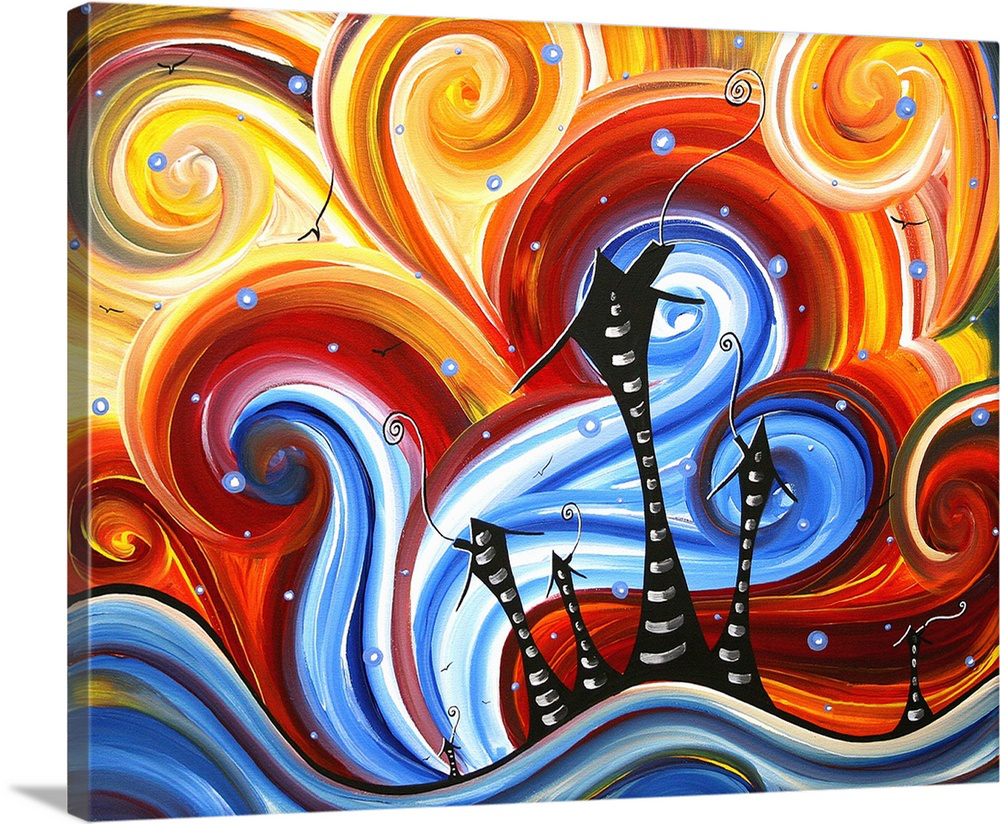

In [7]:
# Chose a style
# !wget https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS-6LzlnFRZeEIpDXonHF7XW0hytix3_C2CN4_wBS1pcg6kjcO6 -O style.jpg
# !wget https://github.com/pytorch/examples/blob/master/fast_neural_style/images/style-images/mosaic.jpg?raw=true -O style.jpg
# !wget https://github.com/lgvaz/projects/blob/master/vision/style/styles/landscape_cove.jpg?raw=true -O style.jpg
!wget https://static.greatbigcanvas.com/images/singlecanvas_thick_none/megan-aroon-duncanson/little-village-abstract-art-house-painting,1162125.jpg -O style.jpg

fn = 'style.jpg'
pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize.from_stats(*imagenet_stats, cuda=False)])
style_timg = TensorImage(pipe(fn).cuda());
PILImage.create(fn)

In [0]:
def gram(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [9]:
!wget https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/neural_style/transformer_net.py -O transformer_net.py
from transformer_net import TransformerNet
from torchvision.models import vgg16, vgg19

--2019-12-16 02:47:32--  https://raw.githubusercontent.com/pytorch/examples/master/fast_neural_style/neural_style/transformer_net.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3782 (3.7K) [text/plain]
Saving to: ‘transformer_net.py’

transformer_net.py  100%[===================>]   3.69K  --.-KB/s    in 0s      

2019-12-16 02:47:32 (45.8 MB/s) - ‘transformer_net.py’ saved [3782/3782]



In [10]:
feat_m = vgg19(True).features.cuda().eval()
for p in feat_m.parameters(): p.requires_grad=False
requires_grad(feat_m)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 151MB/s]


False

In [11]:
# layers = [feat_m[i] for i in [1, 11, 18, 25, 20]]; layers # vgg16
layers = [feat_m[i] for i in [1, 6, 11, 20, 29, 22]]; layers # vgg19

[ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True),
 ReLU(inplace=True)]

In [0]:
def VggFeats(layers):
  hooks = hook_outputs(layers, detach=False)
  def _inner(x):
    feat_m(x)
    return hooks.stored
  return _inner

In [0]:
get_fs = VggFeats(layers)

In [0]:
def cnt_loss_fn(fs, y_fs): return F.mse_loss(fs[-1], y_fs[-1])

In [0]:
def get_stl_fs(fs): return fs[:-1]

stl_fs = get_fs(style_timg)
stl_grams = [gram(f) for f in stl_fs]
def stl_loss_fn(fs, y_fs):
  bs = fs[0].shape[0]
  stl_losses = [F.mse_loss(y_gram.repeat(bs,1,1),gram(f)) for y_gram,f in zip(*map(get_stl_fs, [stl_grams, fs]))]
  return 3e5*sum(stl_losses)

In [0]:
def tv_loss_fn(img):      
  tv_h = ((img[:,:,1:,:] - img[:,:,:-1,:]).pow(2)).mean()
  tv_w = ((img[:,:,:,1:] - img[:,:,:,:-1]).pow(2)).mean()    
  return 10*(tv_h + tv_w)

In [0]:
class FSTLoss(Module):
  def __init__(self, get_fs, stl_loss_fn, cnt_loss_fn, tv_loss_fn):
    super().__init__()
    store_attr(self, 'get_fs,stl_loss_fn,cnt_loss_fn,tv_loss_fn')
    self.reset_metrics()

  def forward(self, pred, targ, **kwargs):
    pred_feats,targ_feats = self.get_fs(pred),self.get_fs(targ)
    assert not (pred_feats[0] == targ_feats[0]).all()
    stl_loss = self.stl_loss_fn(pred_feats, targ_feats)
    cnt_loss = self.cnt_loss_fn(pred_feats, targ_feats)
    tv_loss  = self.tv_loss_fn (pred)
    self._add_loss(stl_loss, cnt_loss, tv_loss)
    return stl_loss+cnt_loss+tv_loss
  
  def reset_metrics(self): self.metrics = dict(style=[], content=[], tv=[])
    
  def _add_loss(self, stl_loss, cnt_loss, tv):
     self.metrics['style'].append(stl_loss),self.metrics['content'].append(cnt_loss),self.metrics['tv'].append(tv)

In [0]:
loss_func = FSTLoss(get_fs, stl_loss_fn, cnt_loss_fn, tv_loss_fn)

In [0]:
# opt_func = lambda ps, lr, **kwargs: Lookahead(RAdam(ps, lr, wd=1e-3, **kwargs))
# opt_func = lambda ps, lr, **kwargs: Lookahead(Adam(ps, lr, wd=1e-3), **kwargs)
opt_func = lambda ps, lr, **kwargs: Adam(ps, lr, **kwargs)

In [0]:
m = TransformerNet().cuda()

In [0]:
learn = Learner(dbch, m, loss_func=loss_func, opt_func=opt_func)

In [25]:
# Only run if in colab
learn.path = root_dir/'dl/style'; learn.path

PosixPath('/content/gdrive/My Drive/dl/style')

In [0]:
learn.load('tn-vgg19-village-512')

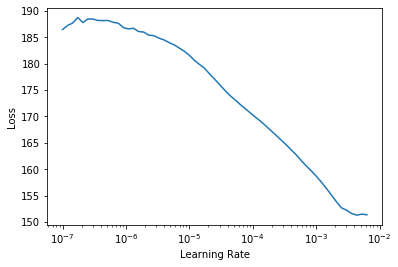

In [23]:
learn.lr_find()

In [26]:
# 15.56, 14.69
learn.fit_one_cycle(1, 1e-3)

In [0]:
learn.save('tn-vgg19-village-512_1')

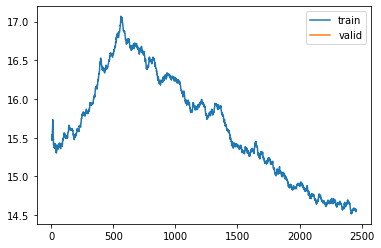

In [0]:
learn.recorder.plot_loss()

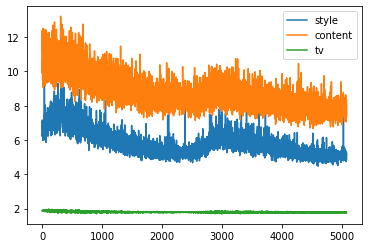

In [0]:
for k, v in loss_func.metrics.items(): plt.plot(v[200:], label=k)
plt.legend()

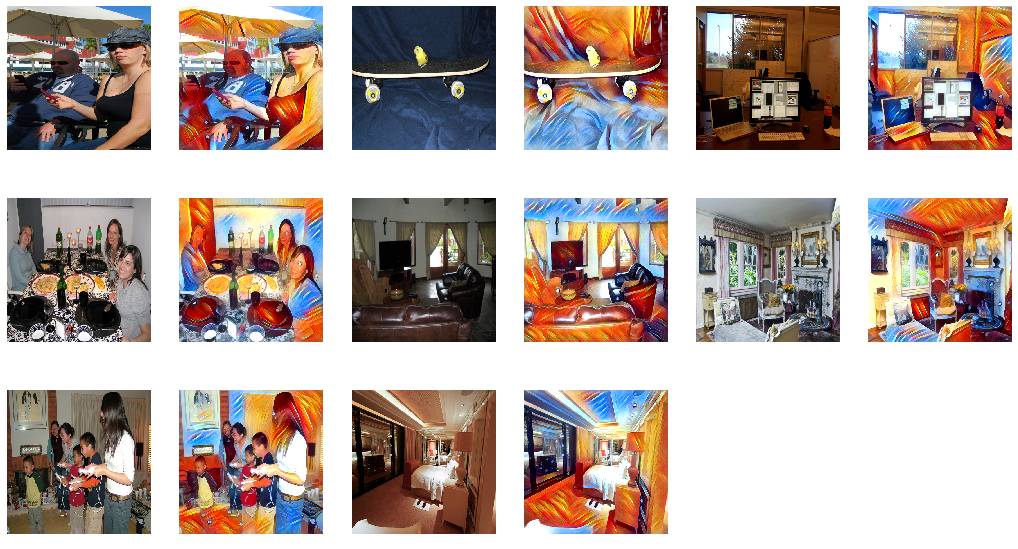

In [0]:
learn.show_results()

In [0]:
test_pipe = Pipeline([PILImage.create, ToTensor(), IntToFloatTensor(), Normalize(*imagenet_stats, cuda=False)])

In [0]:
!wget https://github.com/lgvaz/projects/blob/master/vision/style/tests/chicago.jpg?raw=true -O test.jpg
# !wget https://github.com/pytorch/examples/blob/master/fast_neural_style/images/content-images/amber.jpg?raw=true -O test.jpg

--2019-12-04 03:13:11--  https://github.com/lgvaz/projects/blob/master/vision/style/tests/chicago.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/lgvaz/projects/raw/master/vision/style/tests/chicago.jpg [following]
--2019-12-04 03:13:12--  https://github.com/lgvaz/projects/raw/master/vision/style/tests/chicago.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lgvaz/projects/master/vision/style/tests/chicago.jpg [following]
--2019-12-04 03:13:12--  https://raw.githubusercontent.com/lgvaz/projects/master/vision/style/tests/chicago.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:

In [0]:
timg = test_pipe('test.jpg').cuda()
pred = TensorImage(learn.model(timg)).cpu()

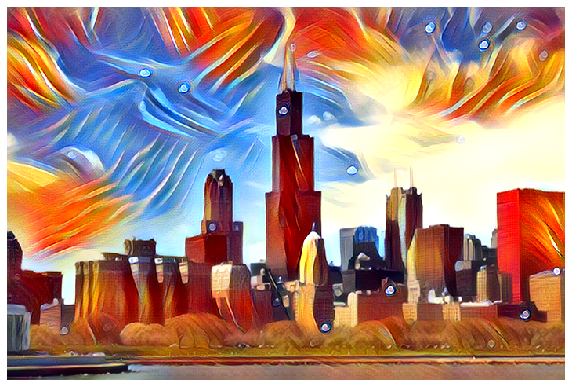

In [0]:
show_images(test_pipe.decode(pred), figsize=(10,10))